# Object Detection with PyTorch and Facebook DETR
This notebook consists of two parts to my self-learning of PyTorch: The first part uses transfer learning with the pre-trained ResNet-18 model in PyTorch on a very small dataset of images, and the second part follows the <a href="https://youtu.be/LfUsGv-ESbc">Facebook DETR tutorial video</a> by Yannic Kilcher.

## Part 1: Transfer Learning with ResNet-18
In this section, I'm learning to use transfer learning with a pre-trained ResNet-18 model to be trained and evaluated on bear, gorilla, and other images. This is also part of my learning on using PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")

CUDA is available.


In [3]:
# Utilize CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Mean and std from the ImageNet dataset
mean = np.array([0.485, 0.456, 0.496])
std = np.array([0.229, 0.224, 0.225])

# For transforming image into tensor and applying normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
# Import data
data_dir = "datasets/animals"
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in sets}

dataloader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            shuffle=True, num_workers=0)
             for x in sets}

In [6]:
# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
print(dataset_sizes)

{'train': 150, 'val': 60}


In [7]:
# Get class names
class_names = image_datasets['train'].classes
print(class_names)

['bear', 'gorilla', 'other']


The dataset we are working with here contains 150 images for training and 60 images for validation, and it contains 3 classes: bear, gorilla, and other.

In [8]:
# Function that trains and validate the model
def train_model(mode, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs + 1):
        if (epoch + 1) == 1 or (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in sets:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if (epoch + 1) == 1 or (epoch + 1) % 10 == 0:
                print(f'{phase} \t Loss: {epoch_loss:.4f} \t Acc: {epoch_acc:.4f}')
                print()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Load pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features

# Give the model a new FC layer with number of classes in our case
model.fc = nn.Linear(num_ftrs, len(class_names))
model.to(device)  # Use CUDA if available

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

After loading the pre-trained ResNet-18 model, we can freeze all layers, such that the trained weight of the layers will not be changed. The final fully connected (FC) layer is replaced with a new FC layer of matching number of classes to our dataset, as we can observe in the last line <code>(fc): Linear(in_features=512, out_features=3, bias=True)</code>.

In [10]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

# Scheduler: for every 7 epochs, multiply the LR by gamma (0.1)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train 	 Loss: 1.1363 	 Acc: 0.4067

val 	 Loss: 1.0104 	 Acc: 0.4833

Epoch 10/100
----------
train 	 Loss: 0.7081 	 Acc: 0.7200

val 	 Loss: 0.5462 	 Acc: 0.8167

Epoch 20/100
----------
train 	 Loss: 0.6527 	 Acc: 0.8267

val 	 Loss: 0.5315 	 Acc: 0.8167

Epoch 30/100
----------
train 	 Loss: 0.6999 	 Acc: 0.7133

val 	 Loss: 0.5301 	 Acc: 0.8167

Epoch 40/100
----------
train 	 Loss: 0.6993 	 Acc: 0.7133

val 	 Loss: 0.5342 	 Acc: 0.8167

Epoch 50/100
----------
train 	 Loss: 0.7407 	 Acc: 0.7000

val 	 Loss: 0.5459 	 Acc: 0.8167

Epoch 60/100
----------
train 	 Loss: 0.7038 	 Acc: 0.7667

val 	 Loss: 0.5149 	 Acc: 0.8167

Epoch 70/100
----------
train 	 Loss: 0.6907 	 Acc: 0.7200

val 	 Loss: 0.5213 	 Acc: 0.8167

Epoch 80/100
----------
train 	 Loss: 0.7095 	 Acc: 0.7733

val 	 Loss: 0.5050 	 Acc: 0.8167

Epoch 90/100
----------
train 	 Loss: 0.7289 	 Acc: 0.7200

val 	 Loss: 0.5301 	 Acc: 0.8167

Epoch 100/100
----------
train 	 Loss: 0.6612 	 Acc: 0.7533



The accuracy is pretty limited as we can observe the loss and accuracy in the training and validation phases. The validation accuracy appears to peak around 85 to 86%.

---
## Part 2: Facebook DETR
In this section, I'm learning to leverage the <a href="https://github.com/facebookresearch/detr">Facebook DETR</a>, an end-to-end object detection with transformers, in detecting and labeling objects in the image and will be outputing an image with the bouding boxes, following the <a href="https://youtu.be/LfUsGv-ESbc">tutorial video</a> by Yannic Kilcher. I'll be using the pre-trained ResNet-101 model as used in the tutorial.

In [12]:
# Import necessary libraries
import requests
from PIL import Image, ImageDraw, ImageFont

In [13]:
# Load Facebook DETR model
model = torch.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

Using cache found in C:\Users\Kevin C/.cache\torch\hub\facebookresearch_detr_master


In [14]:
# Input image address
url = input()

https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/ostrich-zebras-and-giraffe-garry-gay.jpg


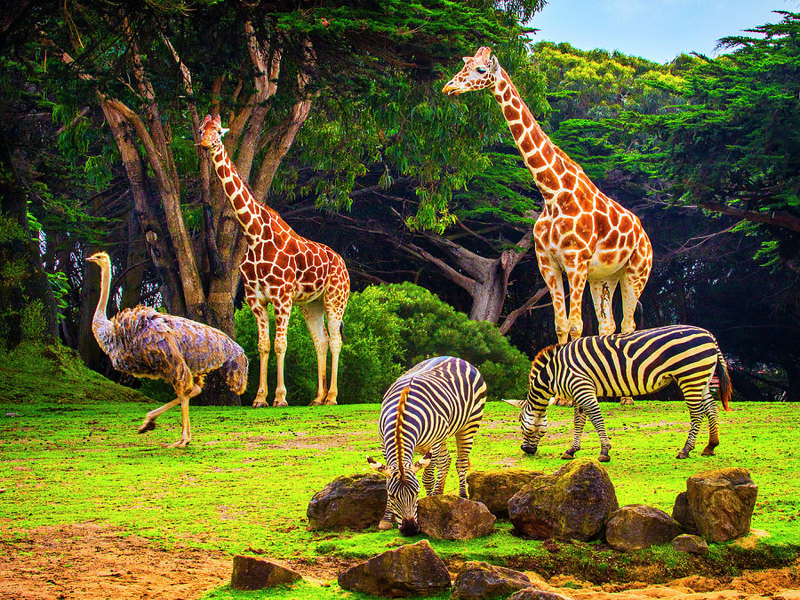

In [15]:
# Taking a peek at the image
img = Image.open(requests.get(url, stream=True).raw).resize((800,600))
img

The image is a little squished after we resized it, but it should still be ok.

The image I selected contains 2 giraffes, 2 zebras, and 1 ostrich. Of which, the ostrich is not in the classes in the pre-trained model, and I'm a little curious what the prediction will be.

In [16]:
# Standard PyTorch input image normalization
transform = transforms.Compose([
    transforms.Resize(800),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

We need to transform the image into a tensor, and we apply <code>cuda()</code> to leverage our GPU.

In [17]:
img_tensor = transform(img).unsqueeze(0).cuda()

In [18]:
# Makes prediction
with torch.no_grad():
    output = model(img_tensor)

In [19]:
print(output['pred_boxes'][0].shape)
print(output['pred_logits'][0].shape)

torch.Size([100, 4])
torch.Size([100, 92])


The output for the 1st line means that there are 100 bounding boxes, with each having 4 numbers, and the output for the 2nd line means that there are 100 logits and each one is of size 92 (91 classes and 1 additional class of 'nothing').

We need to perform softmax on the predicted logits, as it will normalize Facebook DETR's predictions to between 0 and 1. The top K (here I'll set to 5) predictions will be selected:

In [20]:
pred_logits = output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes = output['pred_boxes'][0]

# Perform softmax on predicted logits
max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(5)

In [21]:
topk

torch.return_types.topk(
values=tensor([0.9998, 0.9997, 0.9997, 0.9993, 0.9933], device='cuda:0'),
indices=tensor([14, 50, 26, 38, 56], device='cuda:0'))

In [22]:
# Get only the top K logits and bounding boxes
pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([5, 91])

Once we have the normalized logits and associated bounding boxes, we can draw the bounding boxes and labels on the image:

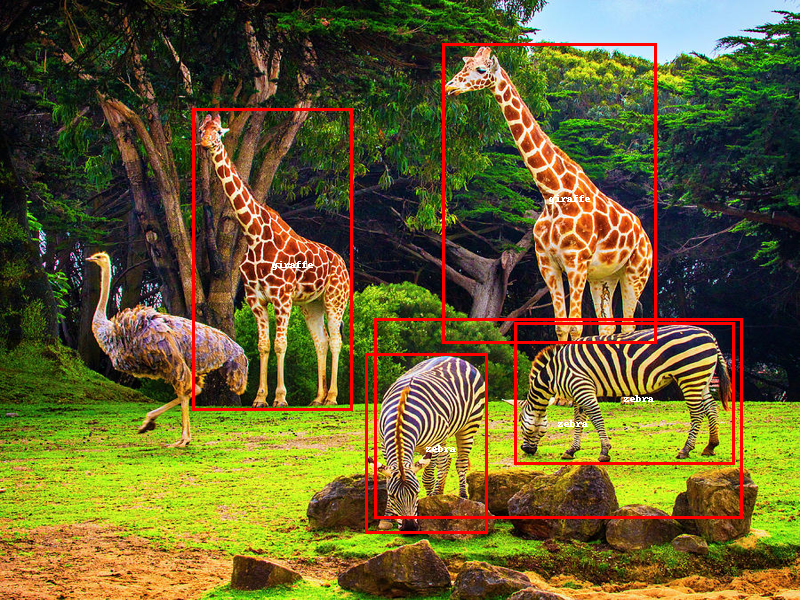

In [23]:
img2 = img.copy()  # Make a copy of the original image for us to play with
drw = ImageDraw.Draw(img2)

for logits, boxes in zip(pred_logits, pred_boxes):
    cls = logits.argmax() # Get the predicted class
    if cls >= len(CLASSES):
        continue
    label = CLASSES[cls] # Get the label
    # print(label)
    
    # Draw the bounding boxes on the image   
    boxes = boxes.cpu() * torch.Tensor([800, 600, 800, 600])
    x, y, w, h = boxes
    x0, x1 = x-w//2, x+w//2
    y0, y1 = y-h//2, y+h//2
    drw.rectangle([x0, y0, x1, y1], outline='red', width=3)
    drw.text((x, y), label, fill='white')
    
img2

We can observe that the Facebook DETR could correctly detect the giraffes and zebras in the top 5 predictions, but the ostrich is not among the top 5 predictions. This seems very reasonable, because ostrich is not one of the previously trained classes, and even if it is detected, it is likely to be mis-classified.